# Generalized Additive Models

We will use the PyGAM package (https://pygam.readthedocs.io/en/latest/notebooks/quick_start.html) to fit GAMs on the Wage dataset, which has been used for demonstrations throughout your textbooks and these lectures.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pygam import s, l, f, LinearGAM, LogisticGAM

In [3]:
df = pd.read_csv('Wage.csv')
df

,Unnamed: 0,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,376816,2008,44,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293
2996,302281,2007,30,1. Male,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464
2997,10033,2005,27,1. Male,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408
2998,14375,2005,27,1. Male,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033


In the below code, 's' means to fit a spline on a particular predictor and 'f' means to fit a coefficient on each level of a factor, the '0/1/2' arguments tell it which predictor (0-indexed) in X to operate on, and 'lam' is the penalty/smoothing parameter. Note we do not want a penalization term on the predictor that's a factor so we set lam=0 on component index 2.

In [4]:
pd.Categorical(df['education'])

['1. < HS Grad', '4. College Grad', '3. Some College', '4. College Grad', '2. HS Grad', ..., '3. Some College', '2. HS Grad', '1. < HS Grad', '3. Some College', '2. HS Grad']
Length: 3000
Categories (5, object): ['1. < HS Grad', '2. HS Grad', '3. Some College', '4. College Grad', '5. Advanced Degree']

In [5]:
y = df['wage']
X = np.column_stack([
    df['age'],
    df['year'],
    pd.Categorical(df['education']).codes,  # yet another way to convert to categorical
])
gam = LinearGAM(
    s(0, lam=0.6) +
    s(1, lam=0.6) + 
    f(2, lam=0) # factor is a discrete model and you would not want to smooth it
    )  
gam.fit(X, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

## Partial dependence plots

We can analyze the model for each $X_j$ separately in terms of partial dependence plots (https://scikit-learn.org/stable/modules/partial_dependence.html).

The PyGAM package provides useful convenience functions to compute these plots for us.

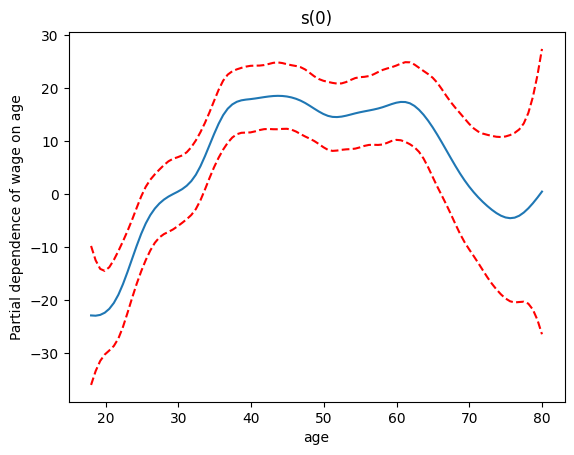

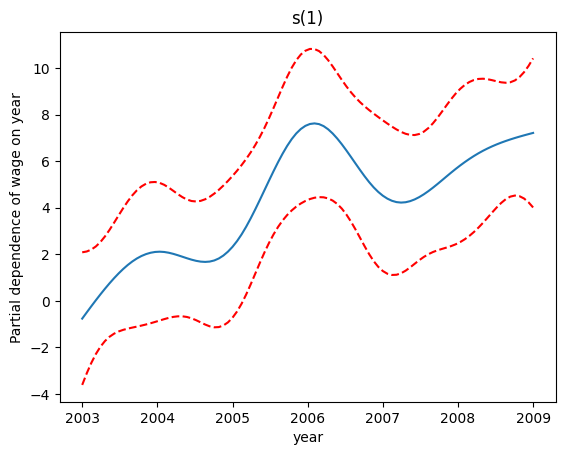

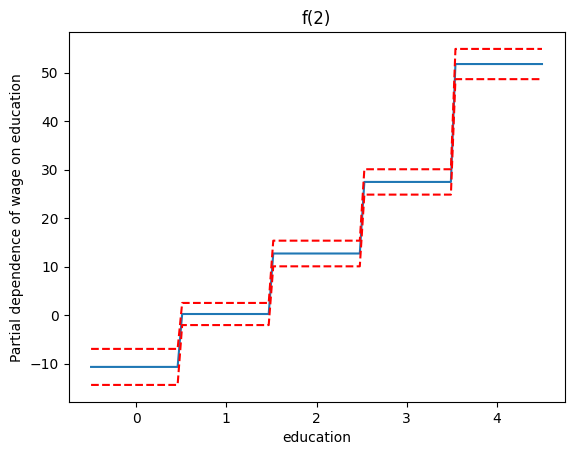

In [6]:
xlabels = ['age', 'year', 'education']

for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.xlabel(xlabels[i])
    plt.ylabel(f"Partial dependence of wage on {xlabels[i]}")
    plt.show()

In [7]:
# to see the 
pd.Categorical(df['education']).categories

Index(['1. < HS Grad', '2. HS Grad', '3. Some College', '4. College Grad',
       '5. Advanced Degree'],
      dtype='object')

We also have a helper function that can help us grid search over the penalty parameter

In [8]:
lam = np.logspace(-3, 5, 5)
lams = [lam] * 3
lams

[array([1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05]),
 array([1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05]),
 array([1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05])]

In [9]:
gam.gridsearch(X, y, lam=lams)
gam.summary()

  0% (0 of 125) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  1% (2 of 125) |                        | Elapsed Time: 0:00:00 ETA:   0:00:04
  3% (4 of 125) |                        | Elapsed Time: 0:00:00 ETA:   0:00:04
  5% (7 of 125) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:03
  8% (10 of 125) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:03
  9% (12 of 125) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:03
 12% (15 of 125) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:03
 14% (18 of 125) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:03
 16% (21 of 125) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:03
 18% (23 of 125) |####                   | Elapsed Time: 0:00:00 ETA:   0:00:03
 20% (26 of 125) |####                   | Elapsed Time: 0:00:00 ETA:   0:00:03
 21% (27 of 125) |####                   | Elapsed Time: 0:00:00 ETA:   0:00:03
 23% (29 of 125) |#####                 

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      9.6668
Link Function:                     IdentityLink Log Likelihood:                                 -24119.413
Number of Samples:                         3000 AIC:                                            48260.1595
                                                AICc:                                           48260.2428
                                                GCV:                                             1244.2375
                                                Scale:                                           1237.0229
                                                Pseudo R-Squared:                                   0.2916
Feature Function                  Lam

/var/folders/7j/0rhz18qs4d9dzfjkz9p2xlcr0000gn/T/ipykernel_63695/3504167213.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


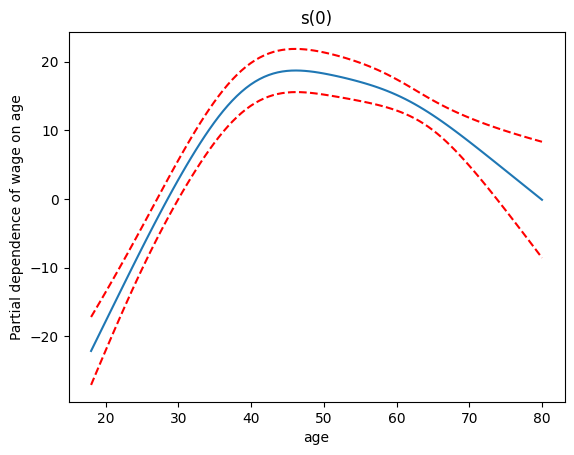

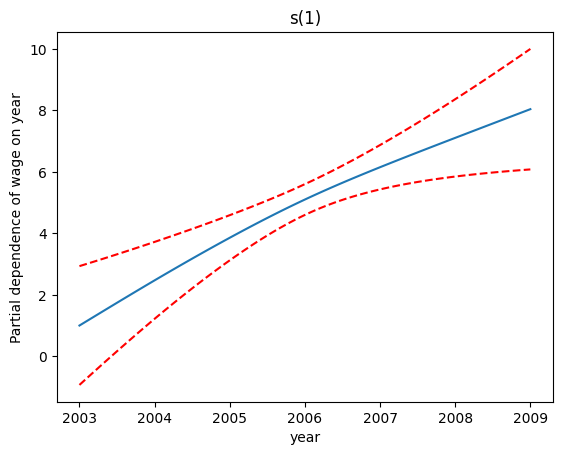

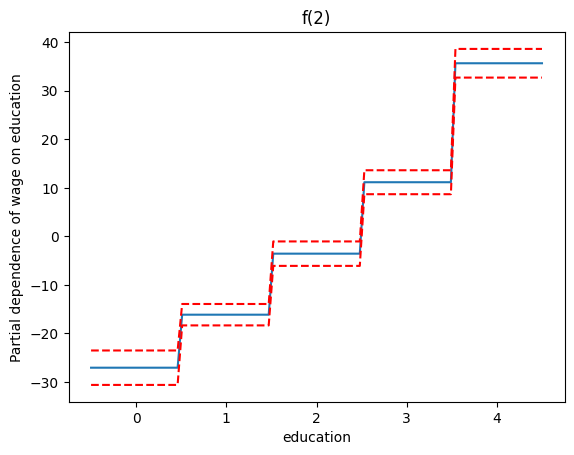

In [10]:
xlabels = ['age', 'year', 'education']

for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.xlabel(xlabels[i])
    plt.ylabel(f"Partial dependence of wage on {xlabels[i]}")
    plt.show()

In [74]:
100000/3000

33.333333333333336